### cifia cnn
- make datasets class
- make cnn model class
- make train & test function
- make predct function

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optima
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import torchinfo, torchmetrics
from torchmetrics.classification import F1Score, Accuracy, ConfusionMatrix
from torchinfo import summary

import torchvision

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
LABEL_TRANSLATE = {0: 'airplane', 1: 'automobile',2: 'bird', 3: 'cat', 4: 'deer',
                   5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
# 함수 선언 하기 전에 설정하는 거
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_STATE = 38
torch.manual_seed(RANDOM_STATE)

In [3]:
# 기본 확인 하는 utils
def utils():
    """
    utils: package version, random_state, device
    ---
    - random_state
    - device
    - pandas version
    - numpy version
    - matplotlib version
    - scikit-learn version
    - torch version
    - torchinfo version
    - torchvision version
    - torchmetrics version
    """
    print('--- Notice ---')
    print(f"random_state: {RANDOM_STATE}")
    print(f"device: {DEVICE}\n")
    
    print(f"pandas ver: {pd.__version__}")
    print(f"numpy ver: {np.__version__}")
    print(f"matplotlib ver: {matplotlib.__version__}")
    print(f"scikit-learn ver: {sklearn.__version__}\n")
    
    print(f"torch ver: {torch.__version__}")
    print(f"torchinfo ver: {torchinfo.__version__}")
    print(f"torchvision ver: {torchvision.__version__}")
    print(f"torchmetrics ver: {torchmetrics.__version__}\n")

In [4]:
utils()

--- Notice ---
random_state: 38
device: cpu

pandas ver: 2.0.3
numpy ver: 1.24.3
matplotlib ver: 3.7.2
scikit-learn ver: 1.3.2

torch ver: 2.4.1
torchinfo ver: 1.8.0
torchvision ver: 0.19.1
torchmetrics ver: 1.4.2



In [5]:
train_df = pd.read_csv('../data/CIFIA/train.csv')
test_df = pd.read_csv('../data/CIFIA/test.csv')

In [38]:
# CIFIA10 CNN model class
# ---------------------------------------------------------
# class perpose: 0 ~ 9 fashion mnist multi classification
# class name: CIFIA10CNNModel
# parents class: nn.Module
# parameters: None
# attribute field: layer1, layer2 fc1, drop, fc2, fc3
# class function: create model structure, forward learning model
# class structure
# - layer1: conv2d(input:1, output:32, kernel:3*3, padding:1 to 0,), batch normalization, activate function: ReLU, maxpooling)
# - layer2: conv2d(input:32, output:64, kernel:3*3, padding:None), batch normalization, activate function: ReLU, maxpooling)
# - fc1: input node: 64*6*6, output node: 600, activate function: None
# - drop: 0.25
# - fc2: input node: 600, output node: 120, activate function: None
# - fc3: input node: 120, output node: 10, activate function: None

class CIFIA10CNNModel(nn.Module):
    """
    Fashion MNIST DNN multi classification model
    ---
    - parents class: nn.Module
    - parameters: None
    - attribute field: layer1, layer2 fc1, drop, fc2, fc3
    - class function: create model structure, forward learning model
    - class structure
        - cnn_layer
            - convloution layer: conv2d(input:3, output:10, kernel:3*3), activaite function: ReLU
            - pooling layer: Maxpooling(kernel: 2*2, stride: 2)
        - dnn_layer
            - hidden layer: input node: 10*15*15, output node: 1000, activate function: ReLU
            - hidden layer: input node: 1000, output node: 500, activate function: ReLU
            - hidden layer: input node: 500, output node: 100, activate function: ReLU
            - output: input node: 100, output node: 10, activate function: None
    ---
    function
    - __init__()
    - forward()
    """
    def __init__(self):
        super().__init__()
        
        # feature sample
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels= 10, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # nn.Flatten()
        )
        # full connext
        self.dnn_layer = nn.Sequential(
            nn.Linear(in_features=10*15*15, out_features=1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
        
    def forward(self, input_):
        output = self.cnn_layer(input_)
        # print(f"[output 1] - {output.shape}")
        
        output = output.view(output.size(0), -1)
        # print(f"[output 2] - {output.shape}")
        
        y = self.dnn_layer(output)
        # print(f"[output 3] - {output.shape}")
        return y

In [39]:
cnn_model = CIFIA10CNNModel()

print(cnn_model)
summary(cnn_model, input_size=(100, 3, 32, 32))

CIFIA10CNNModel(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dnn_layer): Sequential(
    (0): Linear(in_features=2250, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
CIFIA10CNNModel                          [100, 10]                 --
├─Sequential: 1-1                        [100, 10, 15, 15]         --
│    └─Conv2d: 2-1                       [100, 10, 30, 30]         280
│    └─ReLU: 2-2                         [100, 10, 30, 30]         --
│    └─MaxPool2d: 2-3                    [100, 10, 15, 15]         --
├─Sequential: 1-2                        [100, 10]                 --
│    └─Linear: 2-4                       [100, 1000]               2,251,000
│    └─ReLU: 2-5                         [100, 1000]               --
│    └─Linear: 2-6                       [100, 500]                500,500
│    └─ReLU: 2-7                         [100, 500]                --
│    └─Linear: 2-8                       [100, 100]                50,100
│    └─ReLU: 2-9                         [100, 100]                --
│    └─Linear: 2-10                      [100, 10]                 1

In [25]:
# train dataset class
# ------------------------------------------------------------
# dataset: 'train.csv'
# parents class: torch.utils.data.Dataset
# class name: CIFIA10TrainDataset
# feature: pixel
# label: 0 ~ 9, label
# parameter: data_df
# attribute field: data_df, feature_df, label_df, X_train_ts, X_val_ts, y_train_ts, y_val_ts, n_rows, features, n_features, labels, n_lables
# class function: create dataset structure, length, get dataset bach size
# class structure
#   - __init__(self)
#   - __len__(self)
#   - __getitem__(self)

class CIFIA10TrainDataset(Dataset):
    """
    Train CIFIA10 Dataset
    ---
    - parameter: data_df
    - attrubute: data_df, feature_df, label_df, X_train_ts, X_val_ts, y_train_ts, y_val_ts, n_rows, features, n_features, labels, n_labels
    ---
    function
    - __init__()
    - __len__()
    - __getitem__()
    """
    def __init__(self, data_df):
        super().__init__()
        
        self.data_df = data_df
        self.feature_df = data_df[data_df.columns[:-1]]
        label_sr = data_df[data_df.columns[-1]]
        self.laber_df = pd.get_dummies(label_sr).astype('int64')
        
        # stratify: self.label_df
        # train : validation = 7 : 3
        X_train, X_val, y_train, y_val = train_test_split(self.feature_df, self.laber_df, stratify=self.laber_df, test_size=0.3, random_state=RANDOM_STATE)
        # scaler = StandardScaler()
        # scaler.fit(X_train, y_train)
        # X_train = scaler.transform(X_train)
        # X_val = scaler.transform(X_val)
        
        self.X_train_ts = torch.Tensor(X_train.values).reshape(-1, 3, 32, 32)
        self.X_val_ts = torch.Tensor(X_val.values).reshape(-1, 3, 32, 32)
        self.y_train_ts = torch.FloatTensor(y_train.values)
        self.y_val_ts = torch.FloatTensor(y_val.values)
        
        self.n_rows = X_train.shape[0]
        self.features = self.feature_df.columns
        self.n_features = len(self.features)
        self.labels = data_df[data_df.columns[-1]].unique()
        self.n_labels = len(self.labels)
        
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, idx):
        X_train_ts = self.X_train_ts[idx]
        y_train_ts = self.y_train_ts[idx]
        return X_train_ts, y_train_ts


In [64]:
# test dataset class
# ------------------------------------------------------------
# dataset: 'test.csv'
# parents class: torch.utils.data.Dataset
# class name: CIFIA10TrainDataset
# feature: pixel
# label: 0 ~ 9, label
# parameter: data_df
# attribute field: data_df, feature_df, label_df, X_train_ts, X_val_ts, y_train_ts, y_val_ts, n_rows, features, n_features, labels, n_lables
# class function: create dataset structure, length, get dataset bach size
# class structure
#   - __init__(self)
#   - __len__(self)
#   - __getitem__(self)

class CIFIA10TestDataset(Dataset):
    """
    Train CIFIA10 Dataset
    ---
    - parameter: data_df
    - attrubute: data_df, feature_df, label_df, X_test_ts, y_tset_ts, n_rows, features, n_features, labels, n_labels
    ---
    function
    - __init__()
    - __len__()
    - __getitem__()
    """
    def __init__(self, data_df):
        super().__init__()
        
        self.data_df = data_df
        self.feature_df = data_df[data_df.columns[:-1]]
        label_sr = data_df[data_df.columns[-1]]
        self.laber_df = pd.get_dummies(label_sr).astype('int64')
        
        self.X_test_ts = torch.Tensor(self.feature_df.values).reshape(-1, 3, 32, 32)
        self.y_test_ts = torch.FloatTensor(self.laber_df.values)
        
        self.n_rows = self.feature_df.shape[0]
        self.features = self.feature_df.columns
        self.n_features = len(self.features)
        self.labels = data_df[data_df.columns[-1]].unique()
        self.n_labels = len(self.labels)
        
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, idx):
        X_test_ts = self.X_test_ts[idx]
        y_test_ts = self.y_test_ts[idx]
        return X_test_ts, y_test_ts


In [65]:
test_datasets = CIFIA10TestDataset(test_df)

In [28]:
train_datasets = CIFIA10TrainDataset(train_df)

In [66]:
test_datasets.y_test_ts.shape

torch.Size([10000, 10])

In [30]:
train_datasets.labels

array(['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship',
       'cat', 'dog', 'airplane'], dtype=object)

In [32]:
# predict function
# -----------------------------------------------------
# - function name: predict
# - parameter: model, X_data
# - function return: loss, score_accuracy, score_f1score, proba
# -----------------------------------------------------
# must not update weight & bais

def predict(model, X_data):
    """
    Predict function

    Args:
        model (model instance): testing model
        X_data (tensor): feature tensor

    Returns:
        int: predicted number
    """
    
    with torch.no_grad():
        pred = model(X_data).argmax().item()
        pred = LABEL_TRANSLATE[pred]
        
    return pred


In [42]:
# validation & test function
# -----------------------------------------------------
# - function name: testing
# - parameter: model, x_data, y_data
# - function return: loss, score_accuracy, score_f1score, proba
# -----------------------------------------------------
# must not update weight & bais

def testing(model, X_data, y_data):
    """
    Validation & Test function

    Args:
        model (model instance): testing model
        x_data (tensor): feature tensor
        y_data (tensor): label tensor

    Returns:
        tuple: loss, accuracy score, f1 score
    """
    
    with torch.no_grad():
        pred = model(X_data)
        # y_data = y_data.reshape(-1).long()
        loss = nn.CrossEntropyLoss()(pred, y_data)
        
        acc_score = Accuracy(task='multilabel', num_classes=10, num_labels=10)(pred, y_data)
        f1_score = F1Score(task='multilabel', num_classes=10, num_labels=10)(pred, y_data)
        
    return loss, acc_score, f1_score

In [41]:
# model learning
# -------------------------------------------------------------
# - function name: training
# - parameter: dataset, model, epochs, lr, batch_size, patience
# - function return: loss, accuracy score, f1 score, proba
# - optimizer: Adam
# - scheduler: ReduceLROnPlatea, standard: val_loss

def training(dataset, model, epochs, lr=0.001, batch_size=32, patience=10):
    """
    model training function
    - optimizer: Adam
    - scheduler: ReduceLROnPlatea, standard: val_loss

    Args:
        dataset (dataset instance): traing datasets
        model (model instance): model instance
        epochs (int): learning count
        lr (float, optional): learning rate. Defaults to 0.001.
        batch_size (int, optional): batch_size. Defaults to 32.
        patience (int, optional): model performance count threshold. Defaults to 10.

    Returns:
        tuple: loss dict, accuracy dict, f1-score dict
    """
    loss_dict = {'train':[], 'val':[]}
    acc_dict = {'train':[], 'val':[]}
    f1_dict = {'train':[], 'val':[]}
    
    optimizer = optima.Adam(model.parameters(), lr=lr)
    data_dl = DataLoader(dataset, batch_size=batch_size, drop_last=False)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, mode='min')
    
    save_param = '../model/CIFIA/multi_clf_params.pth'
    save_model = '../model/CIFIA/multi_clf_model.pth'
    
    for epoch in range(1, epochs+1):
        total_t_loss, total_t_acc, total_t_f1 = 0, 0, 0
        
        
        for X_train, y_train in data_dl:
            batch_cnt = dataset.n_rows / batch_size
            # y_train = y_train.reshape(-1).long()
            
            pred = model(X_train)
            
            loss = nn.CrossEntropyLoss()(pred, y_train)
            total_t_loss += loss
            
            a_score = Accuracy(task='multilabel', num_classes=10, num_labels=10)(pred, y_train)
            total_t_acc += a_score
            f_score = F1Score(task='multilabel', num_classes=10, num_labels=10)(pred, y_train)
            total_t_f1 += f_score
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        X_val, y_val = dataset.X_val_ts, dataset.y_val_ts
        val_loss, val_acc, val_f1 = testing(model, X_val, y_val)
        
        train_loss = (total_t_loss/batch_cnt).item()
        train_acc = (total_t_acc/batch_cnt).item()
        train_f1 = (total_t_f1/batch_cnt).item()
        
        loss_dict['train'].append(train_loss)
        loss_dict['val'].append(val_loss)
        acc_dict['train'].append(train_acc)
        acc_dict['val'].append(val_acc)
        f1_dict['train'].append(train_f1)
        f1_dict['val'].append(val_f1)

        if epoch%5 == 0:
            print(f"[{epoch:5}/{epochs:5}]  [Train]         loss: {train_loss:.6f}, score: {train_acc:.6f}")
            print(f"[{epoch:5}/{epochs:5}]  [Validation]    loss: {val_loss.item():.6f}, score: {val_acc.item():.6f}\n")
        
        if len(acc_dict['val']) == 1:
            print("saved first")
            torch.save(model.state_dict(), save_param)
            torch.save(model, save_model)
        else:
            if acc_dict['val'][-1] >= max(acc_dict['val']):
                print("saved model")
                torch.save(model.state_dict(), save_param)
                torch.save(model, save_model)
                
        scheduler.step(val_loss)
        
        if scheduler.num_bad_epochs >= scheduler.patience:
            print('성능 및 손실의 개선이 없어서 학습을 중단합니다.\n')
            print(f"[{epoch:5}/{epochs:5}]  [Train]         loss: {train_loss:.6f}, score: {train_acc:.6f}")
            print(f"[{epoch:5}/{epochs:5}]  [Validation]    loss: {val_loss.item():.6f}, score: {val_acc.item():.6f}\n")
            break
        
    return loss_dict, acc_dict, f1_dict

In [36]:
EPOCHS = 100
LR = 0.001
BATCH_SIZE = 100

In [43]:
loss_dict, acc_dict, f1_dict = training(train_datasets, cnn_model, EPOCHS, LR, BATCH_SIZE)

saved first
saved model
saved model
saved model
[    5/  100]  [Train]         loss: 0.147604, score: 0.873263
[    5/  100]  [Validation]    loss: 2.480066, score: 0.822987

saved model
saved model
saved model
[   10/  100]  [Train]         loss: 0.084415, score: 0.890486
[   10/  100]  [Validation]    loss: 3.236136, score: 0.832800

saved model
saved model
성능 및 손실의 개선이 없어서 학습을 중단합니다.

[   11/  100]  [Train]         loss: 0.086534, score: 0.891929
[   11/  100]  [Validation]    loss: 3.122572, score: 0.835893



In [45]:
# 그림 그리는 함수
def draw_two_plot(loss, score, title):
    """
    draw loss & score

    Args:
        loss (_type_): _description_
        r2 (_type_): _description_
        title (_type_): _description_
    """
    
    # 축을 2개 사용하고 싶음.
    fig, ax1 = plt.subplots(figsize=(7, 7))
    ax2 = ax1.twinx()
    
    ax1.plot(loss['train'], label=f"train loss mean: {sum(loss['train'])/len(loss['train']):.6f}", color='#5587ED')
    ax1.plot(loss['val'], label=f"validation loss mean: {sum(loss['val'])/len(loss['val']):.6f}", color='#F361A6')
    ax2.plot(score['train'], label=f"train score max: {max(score['train'])*100:.2f} %", color='#00007F')
    ax2.plot(score['val'], label=f"validation score max: {max(score['val'])*100:.2f} %", color='#99004C')
    
    fig.suptitle(f'{title} number CNN multi classification', fontsize=15)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss', fontsize=10, color='#5587ED')
    ax2.set_ylabel('score', fontsize=10, color='#00007F')
    
    fig.legend(fontsize='small', loc='lower left')
    # plt.xticks(np.arange(0, len(loss['train']), 2), labels=[x for x in range(1, len(loss['val'])+1, 2)])
    plt.show()

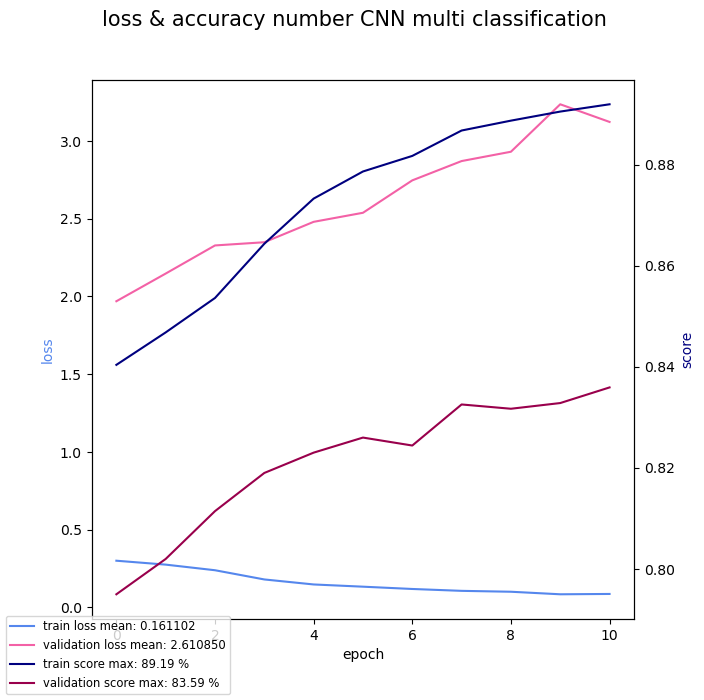

In [46]:
draw_two_plot(loss_dict, acc_dict, 'loss & accuracy')

In [47]:
cnn_model = torch.load('../model/CIFIA/multi_clf_model.pth', weights_only=False)

In [86]:
def predict_show(model, datasets, num):
    """
    show predict fashion item

    Args:
        model (model instance): model predicted list
        datasets (datasets instance): real data list
        num (int): showing image data number
    """
    data_loader = DataLoader(datasets)
    cnt = 0
    for image_datas, labels in data_loader:
        if cnt >= num: pass
        image_data = image_datas
        pred = model(image_datas).argmax().item()
        label = labels.argmax().item()
        cnt += 1
    
    print(f"predict fashion item: {LABEL_TRANSLATE[pred]}")
    print(f"real fashion item: {LABEL_TRANSLATE[label]}\n")

    image_data = image_data.squeeze(0).transpose(0,2)
    print(f"image data: {image_data.shape}, {image_data.ndim}D")

    plt.imshow(image_data)
    plt.title(f"[image - {LABEL_TRANSLATE[label]}]")
    plt.axis('off')
    plt.show()

predict fashion item: horse
real fashion item: horse

image data: torch.Size([32, 32, 3]), 3D


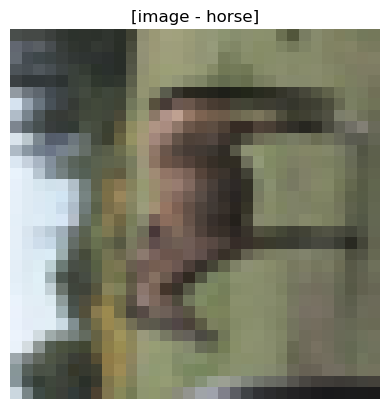

In [87]:
predict_show(cnn_model, test_datasets, 100)

In [88]:
test_loss, test_acc, test_f1 = testing(cnn_model, test_datasets.X_test_ts, test_datasets.y_test_ts)

In [90]:
print(f"test loss: {test_loss:.6f}")
print(f"test accuracy: {test_acc*100:.2f} %")

test loss: 3.161430
test accuracy: 83.60 %


In [116]:
pred = cnn_model(test_datasets.X_test_ts)
pred.shape, test_datasets.y_test_ts.shape
# mat = ConfusionMatrix(task='multiclass', num_classes=10)(pred, test_datasets.y_test_ts)
# mat

(torch.Size([10000, 10]), torch.Size([10000, 10]))

In [123]:
import seaborn as sns

In [122]:
mat = ConfusionMatrix(task='multiclass', num_classes=10)(torch.argmax(pred, dim=1), torch.argmax(test_datasets.y_test_ts, dim=1))
mat

tensor([[786,  14,  35,  16,  15,  12,  10,  12,  54,  46],
        [ 74, 595,  10,  18,   6,   7,  20,  10,  40, 220],
        [147,   4, 404,  64, 131,  78,  94,  34,  23,  21],
        [ 62,  19, 104, 341,  93, 136, 117,  59,  27,  42],
        [ 70,   2, 124,  67, 497,  39,  97,  78,  16,  10],
        [ 64,   8, 107, 142,  68, 417,  65,  87,  16,  26],
        [ 31,   5,  35,  69,  95,  22, 695,  12,  15,  21],
        [ 56,   6,  54,  46,  86,  66,  11, 635,   5,  35],
        [194,  37,  19,  19,  14,   5,  14,   5, 631,  62],
        [ 70,  62,  11,  24,  13,  11,  24,  40,  36, 709]])

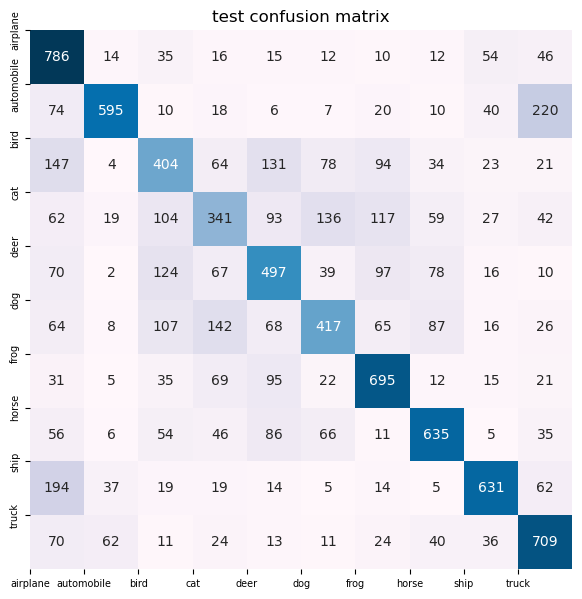

In [133]:
plt.figure(figsize=(7, 7))
sns.heatmap(mat, annot=True, fmt=f'.0f', cmap='PuBu', cbar=False)
plt.title('test confusion matrix')
plt.xticks(np.arange(10), labels=[LABEL_TRANSLATE[x] for x in range(10)], fontsize=7)
plt.yticks(np.arange(10), labels=[LABEL_TRANSLATE[x] for x in range(10)], fontsize=7)
plt.show()